## Wavelet processing with AWI 2-18 GHz SnowRadar
Example of using the wavelet process with AWI data. Note that a child class of the snowradar class is used because  
of differneces in the way the AWI data is structured vs the OIB inputs. The range resolution is quite a bit higher due  
to the larger bandwidth over the 2-8 GHz legacy SnowRadar.

Note this approach is still in testing and has not been validated against in situ data.

&copy; J.King 2018

In [1]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
np.seterr(divide='ignore') # suppress divide-by-zero warnings in below plots
import matplotlib.pyplot as plt
import h5py
from scipy import signal

In [7]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [8]:
radar_file = "./data/awi/Data_20170410_01_006.mat"
radar_dat = snowradar.AWI(radar_file, l_case='full') #Use AWI child class

## Draft surface elevation compensation

In [9]:
er_ice = 3.15
max_elev = radar_dat.elevation.max()
min_elev = np.min(radar_dat.elevation - radar_dat.surface*c/2 -(radar_dat.time_fast[-1]-radar_dat.surface)*c/2/np.sqrt(er_ice))
dr = radar_dat.dft * c/2/np.sqrt(er_ice)
dt_air = dr/(c/2)
dt_ice = dr/(c/2/np.sqrt(er_ice))
elev_axis = np.arange(max_elev,min_elev, -dr)
zero_pad_len = len(elev_axis) - len(radar_dat.time_fast) - 1
radar_comp = np.zeros((zero_pad_len,radar_dat.data_radar.shape[1]))
radar_comp = np.concatenate((radar_dat.data_radar, radar_comp), axis=0)
d_range = max_elev - radar_dat.elevation
d_bins = np.round(d_range / (c/2)/radar_dat.dft)
d_time = d_range/(c/2)

In [10]:
for r_line in np.arange(0, radar_dat.data_radar.shape[1]):
    surf_elev = radar_dat.elevation[r_line] - radar_dat.surface[r_line] * c/2
    time0 = -(max_elev - radar_dat.elevation[r_line])/(c/2)
    last_air_idx = np.argwhere(elev_axis > surf_elev)[-1]
    new_time = (time0 + dt_air*np.arange(0, last_air_idx-1))
    
    if last_air_idx < len(elev_axis):
        first_ice_idx = last_air_idx + 1
        time0 = radar_dat.surface[r_line] + (surf_elev - elev_axis[first_ice_idx]) / (c/2/np.sqrt(er_ice))
        new_time = np.concatenate((new_time, time0 + dt_ice * (np.arange(0, len(elev_axis)-len(new_time)-1))), axis = 0)
    
    radar_comp[:,r_line] = np.interp(new_time,radar_dat.time_fast, radar_dat.data_radar[0:len(radar_dat.time_fast), r_line] )
    radar_dat.elevation[r_line] = radar_dat.elevation[r_line] + d_range[r_line]
    radar_dat.surface[r_line] = radar_dat.surface[r_line] + d_time[r_line]

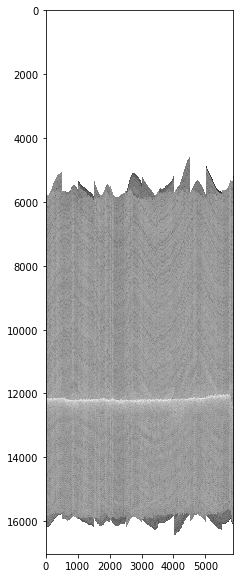

In [16]:
radar_dat.data_radar = radar_comp
radar_dat.surface_elev = radar_dat.elevation - radar_dat.surface*c/2

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(10 * np.log10(radar_dat.data_radar), interpolation='nearest', cmap="gist_gray")
plt.show()

Estimate the pulse width

In [19]:
radar_dat.calcpulsewidth()
print("Equivalent pulse width %f" % (radar_dat.epw))
print("Null-to-null pulse width %f" % (radar_dat.n2n))

Equivalent pulse width 0.028389
Null-to-null pulse width 0.075698


The current AWI data is unfiltered so we apply a boxcar window to knock down the noise a bit  
Window length is arbitrary but maintain a short scale to avoid smoothing actual variability

In [20]:
def RadarWindow(x,window_len=11):
    return np.convolve(
        signal.windows.boxcar(window_len) / signal.windows.boxcar(window_len).sum(),
        x,
        mode='valid'
    )

I'm windowing the numpy array here to speed up the process  
Processing the entire file in one go can be time consuming  
because the current processes are serial with loop  
TODO: Elevation correction will help narrow the fast-time (y-axis) range

In [31]:
radar_sub = radar_dat.data_radar[11000:13000,0:1000]
radar_1d_smooth = np.apply_along_axis(RadarWindow, 0, radar_sub, 5)
radar_2d_smooth = signal.medfilt2d(radar_sub, kernel_size=5)
#radar_1d_window = RadarWindow(radar_sub,10)

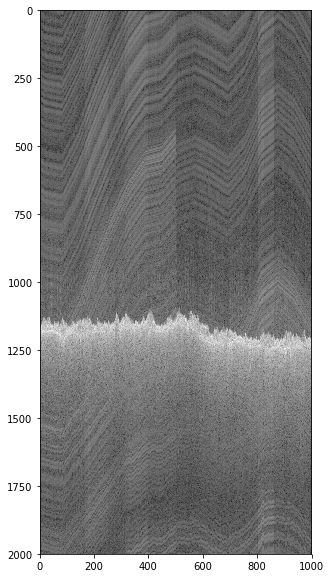

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(10 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
plt.show()

A-Scope example of the raw and smoothed radar traces

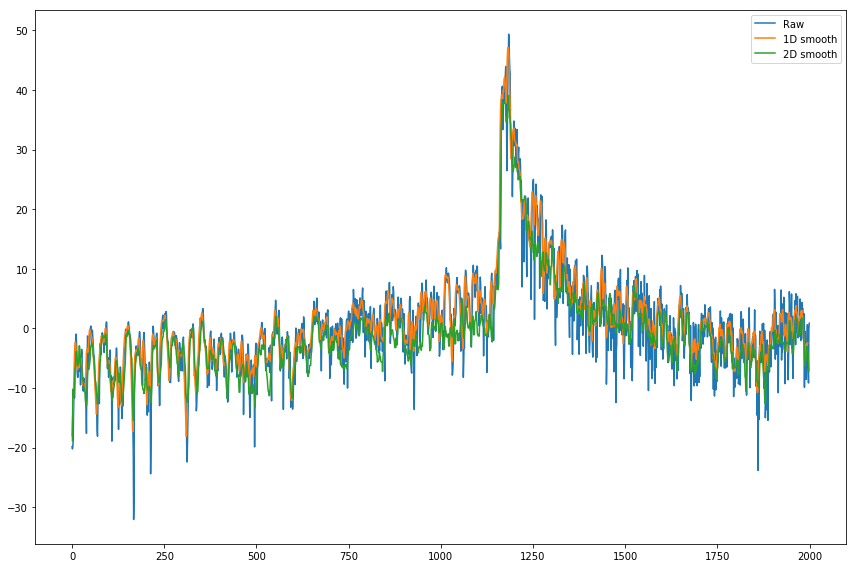

In [33]:
col_idx = 150
fig, ax = plt.subplots(figsize=(12,8))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_sub[:,1]))
ax.plot(10*np.log10(radar_1d_smooth[:,1]))
ax.plot(10*np.log10(radar_2d_smooth[:,1]))
ax.legend(('Raw', '1D smooth', '2D smooth'))
fig.tight_layout();

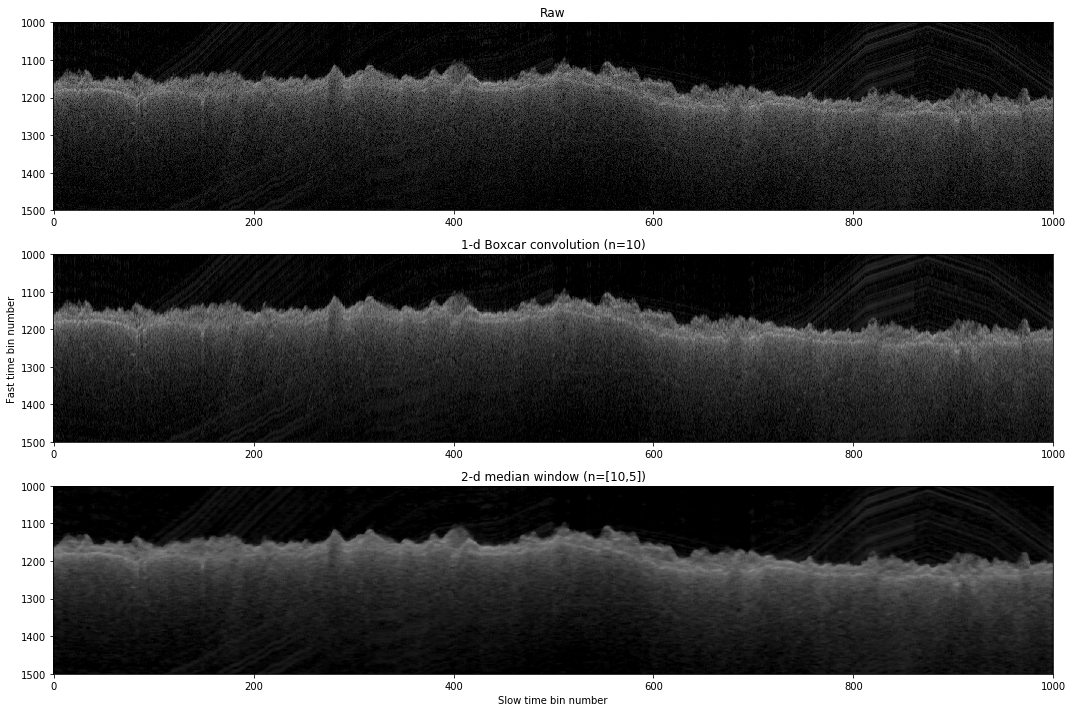

In [34]:
ymin = 1000
ymax = 1500
vis_max = 80
vis_min = 0

fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0].set_title("Raw")
ax[0].imshow(10 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[0].set_aspect('auto')
ax[0].set_ylim([ymax, ymin])
ax[1].set_ylabel("Fast time bin number")
ax[1].set_title("1-d Boxcar convolution (n=10)")
ax[1].imshow(10 * np.log10(radar_1d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[1].set_aspect('auto')
ax[1].set_ylim([ymax, ymin])
ax[2].set_title("2-d median window (n=[10,5])")
ax[2].imshow(10 * np.log10(radar_2d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[2].set_aspect('auto')
ax[2].set_ylim([ymax, ymin])
ax[2].set_xlabel("Slow time bin number")
fig.tight_layout();

Apply the wavelet picker to each radar trace to identify the air-snow and snow-ice interfaces   
Numpy applies a serial process (slow)  
In the future this makes sense to use dask to distribute over N cores

Then calculate the snow depth using an assumption of the refractive index 
The air-snow picks seem to perform well but there is a lot of noise in the snow-ice interface  
Note the standard deviation of the snow depth is ~3/4 of the mean depth. This worries me a bit but not knowing the environment I can't draw a conclusion.   
The result of much more reasonable when averaged over 5 or more bins.  

In [35]:
%time l_as, l_si = np.apply_along_axis(picklayers.picklayers, 0, radar_1d_smooth, radar_dat.n2n, radar_dat.dfr, n_snow)

Wall time: 1min 2s


Max along-track resolution
Mean depth (m): 0.2054520424340752
StDev of  depth (m): 0.1434123686449222

5-bin averaged along-track 
Mean snow depth (m): 0.20581772946356958
StDev of snow depth (m): 0.1166049544676959


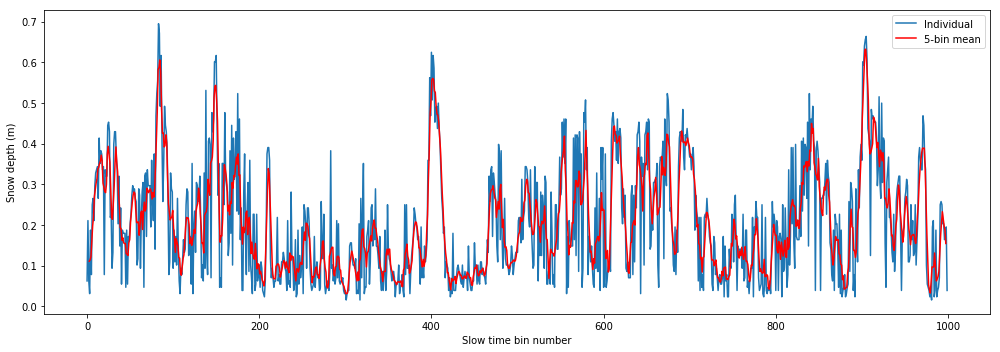

In [36]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
#ax.plot(np.arange(0, len(snow_depth_rollin)),snow_depth_rollin, color='r')
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

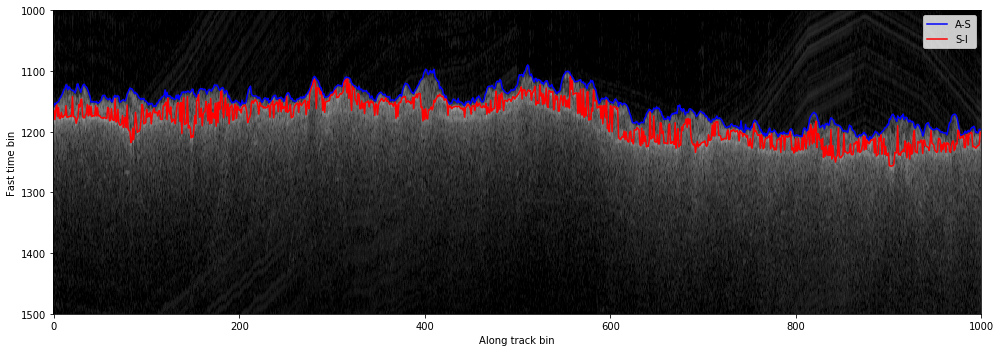

In [37]:
fig, ax = plt.subplots(figsize=(14,5))
ax.imshow(10 * np.log10(radar_1d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
ax.set_ylabel("Fast time bin")
ax.set_xlabel("Along track bin")
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_ylim([ymax, ymin])
ax.set_aspect('auto')
fig.tight_layout();

Sanity check the interface picks.

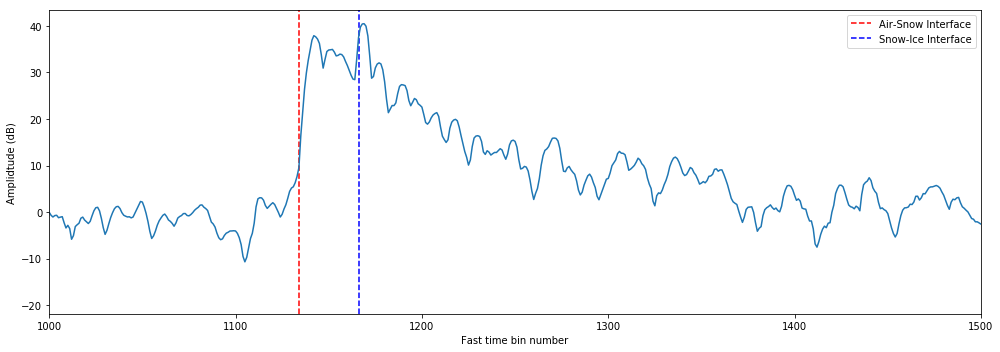

In [42]:
col_idx = np.random.randint(0, radar_1d_smooth.shape[1])
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_1d_smooth[:,col_idx]), label=None)
# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
ax.set_xlim([ymin, ymax])
fig.tight_layout();